In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Paths
DATA_PATH = "C:/Users/lmosquen/Desktop/Python/Ciencia de datos/Día 9/Data/Dataset Mundiales.csv"
IMG_DIR   = "C:/Users/lmosquen/Desktop/Python/Ciencia de datos/Día 9/Images"
os.makedirs(IMG_DIR, exist_ok=True)

# Estética
plt.style.use("default")
plt.rcParams["figure.figsize"] = (10,6)


In [2]:
# 2. Cargar dataset
df = pd.read_csv(DATA_PATH, encoding="latin-1")

# Revisar columnas y tamaño
df.shape, df.columns.tolist()
df.head()


,Key Id,Tournament Id,tournament Name,Match Id,Match Name,Stage Name,Group Name,Group Stage,Knockout Stage,Replayed,...,Away Team Score Margin,Extra Time,Penalty Shootout,Score Penalties,Home Team Score Penalties,Away Team Score Penalties,Result,Home Team Win,Away Team Win,Draw
0,1,WC-1930,1930 FIFA World Cup,M-1930-01,France v Mexico,group stage,Group 1,1,0,0,...,-3,0,0,0-0,0,0,home team win,1,0,0
1,2,WC-1930,1930 FIFA World Cup,M-1930-02,United States v Belgium,group stage,Group 4,1,0,0,...,-3,0,0,0-0,0,0,home team win,1,0,0
2,3,WC-1930,1930 FIFA World Cup,M-1930-03,Yugoslavia v Brazil,group stage,Group 2,1,0,0,...,-1,0,0,0-0,0,0,home team win,1,0,0
3,4,WC-1930,1930 FIFA World Cup,M-1930-04,Romania v Peru,group stage,Group 3,1,0,0,...,-2,0,0,0-0,0,0,home team win,1,0,0
4,5,WC-1930,1930 FIFA World Cup,M-1930-05,Argentina v France,group stage,Group 1,1,0,0,...,-1,0,0,0-0,0,0,home team win,1,0,0


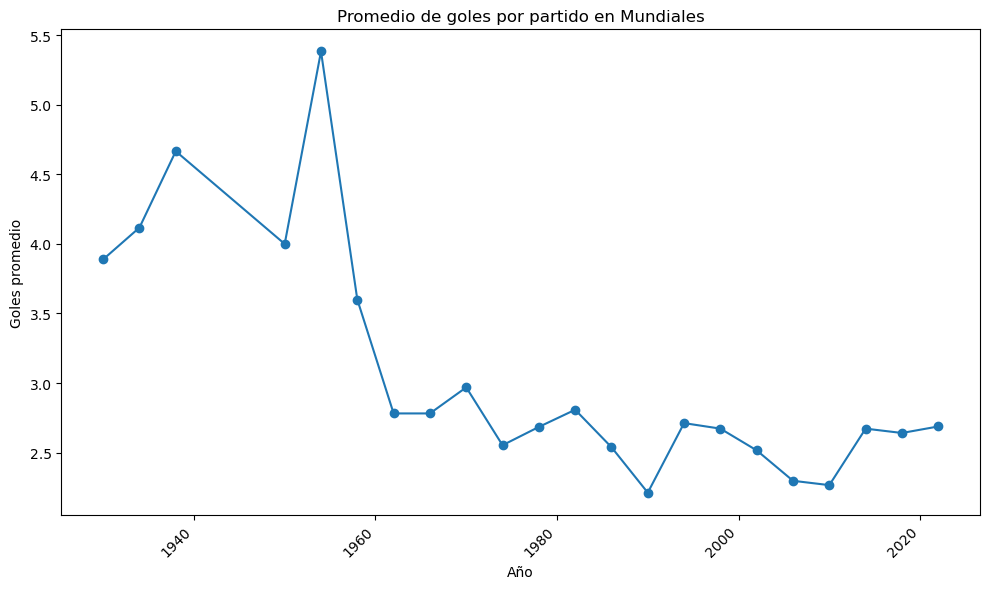

In [3]:
df["Year"] = pd.to_datetime(df["Match Date"]).dt.year

df["Total Goals"] = df["Home Team Score"] + df["Away Team Score"]

goles_por_mundial = df.groupby("Year")["Total Goals"].mean().reset_index()

plt.plot(goles_por_mundial["Year"], goles_por_mundial["Total Goals"], marker="o")
plt.title("Promedio de goles por partido en Mundiales")
plt.xlabel("Año")
plt.ylabel("Goles promedio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/goles_promedio_mundiales.png", dpi=300, bbox_inches="tight")
plt.show()


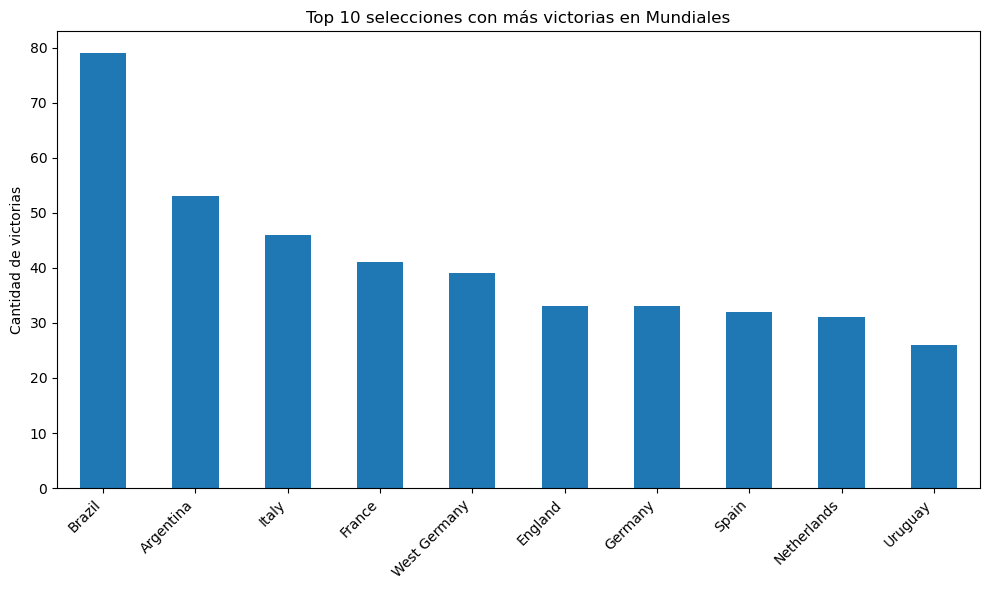

In [4]:
# Filtrar victorias locales y visitantes
victorias_local = df[df["Home Team Win"] == 1]["Home Team Name"].value_counts()
victorias_visit = df[df["Away Team Win"] == 1]["Away Team Name"].value_counts()

victorias_total = (victorias_local.add(victorias_visit, fill_value=0)
                   .sort_values(ascending=False).head(10))

victorias_total.plot(kind="bar")
plt.title("Top 10 selecciones con más victorias en Mundiales")
plt.ylabel("Cantidad de victorias")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/top10_victorias.png", dpi=300, bbox_inches="tight")
plt.show()


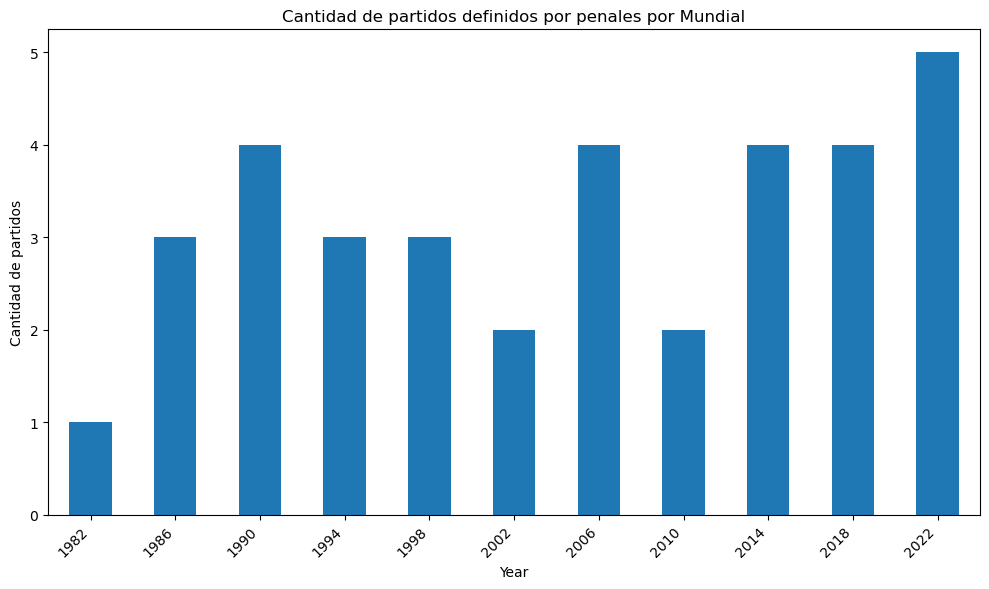

In [5]:
penales_por_mundial = df[df["Penalty Shootout"] == 1].groupby("Year").size()

penales_por_mundial.plot(kind="bar")
plt.title("Cantidad de partidos definidos por penales por Mundial")
plt.ylabel("Cantidad de partidos")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig(f"{IMG_DIR}/partidos_penales.png", dpi=300, bbox_inches="tight")
plt.show()


In [6]:
# 1. Librerías para el modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [7]:
# 2. Crear variable objetivo
df["Resultado"] = df.apply(
    lambda row: "Local" if row["Home Team Win"] == 1 
                else ("Visitante" if row["Away Team Win"] == 1 
                      else "Empate"), axis=1)

df["Resultado"].value_counts()


Resultado
Local        545
Visitante    240
Empate       179
Name: count, dtype: int64

In [8]:
# 3. Selección de variables predictoras
X = df[["Home Team Name", "Away Team Name", "Year", "Stage Name"]]
y = df["Resultado"]

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
# 4. Preprocesamiento: OneHotEncoding para variables categóricas
categorical_features = ["Home Team Name", "Away Team Name", "Stage Name"]
numeric_features = ["Year"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)


In [10]:
# 5. Pipeline con Árbol de Decisión
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(max_depth=5, random_state=42))
])

# Entrenar modelo
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)


              precision    recall  f1-score   support

      Empate       0.50      0.03      0.05        36
       Local       0.60      0.82      0.69       109
   Visitante       0.36      0.31      0.33        48

    accuracy                           0.54       193
   macro avg       0.48      0.39      0.36       193
weighted avg       0.52      0.54      0.48       193



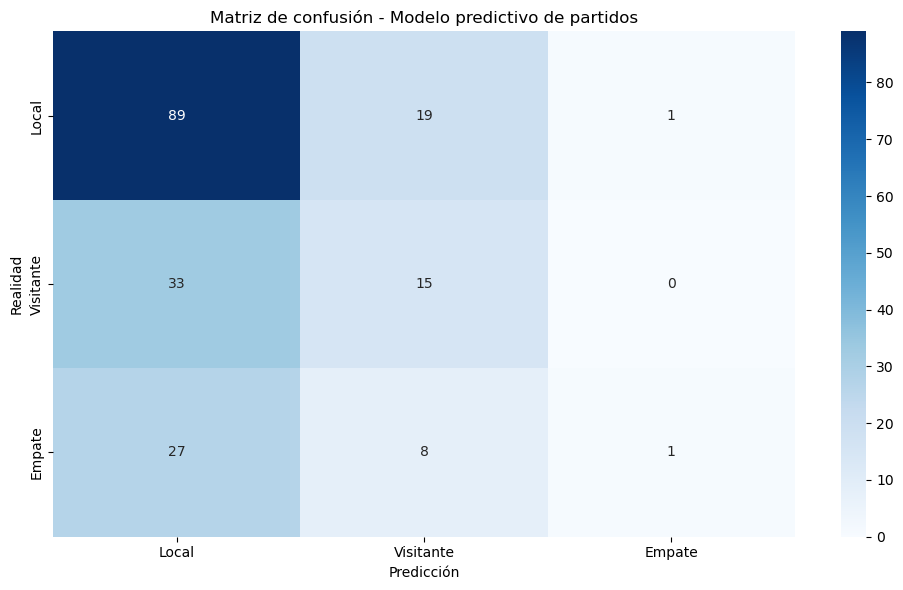

In [11]:
# 6. Evaluación del modelo
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=["Local","Visitante","Empate"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Local","Visitante","Empate"],
            yticklabels=["Local","Visitante","Empate"])
plt.title("Matriz de confusión - Modelo predictivo de partidos")
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.tight_layout()
plt.savefig("../Images/modelo_mundiales_confusion.png", dpi=300, bbox_inches="tight")
plt.show()
